## Install library for calculating SHapley values

In [6]:
pip install shap

##Import libraries

In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
import shap

import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
import plotly

In [9]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "Colab_Notebooks/Projects/RF_MGH_scMGH_exclude14/"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab_Notebooks/Projects/RF_MGH_scMGH_exclude14


## Read datasets for train and test of the model

In [24]:
mgh = pd.read_excel('MGH_TRAINING.xlsx')
scmgh = pd.read_excel('scMGH_TEST.xlsx')

## filter / take 150 first rows (samples) """MGH""" 50 -- 50  conditions [0,1] from MGH_TRAINING_reduced.xlsx

## Drop sample id column

In [25]:
mgh.drop('SAMPLES', axis=1, inplace=True)
scmgh.drop('SAMPLES', axis=1, inplace=True)

## Create datasets with the same columns

In [26]:
scmgh = scmgh[list(scmgh.columns)]

## Convert NPX values to normal distribution for every dataset

In [27]:
col = mgh.drop(['Condition'], axis=1).columns

sc = StandardScaler()

for i in col:
  mgh[[i]] = sc.fit_transform(mgh[[i]])
  scmgh[[i]] = sc.fit_transform(scmgh[[i]])

## Create train and test datasets for the ML models

In [28]:
X = mgh.drop('Condition', axis=1)
y = mgh['Condition']

In [29]:
X_test1 = scmgh.drop('Condition', axis=1)
y_test1 = scmgh['Condition']

## Grid search for the selection of the best parameters for our model

In [30]:
param_grid = {
	'n_estimators': [200, 250, 300, 350],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9, 5, 10, 20],
	'max_leaf_nodes': [3, 6, 9],
  'n_estimators':[200, 250, 300, 350],
  'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
}

In [21]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

## RETURN AND RUN AGAIN FROM SCRATCH WITH WHOLE SAMPLES

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       max_features=None, max_leaf_nodes=6, n_estimators=200)


## Train and test of the models

In [31]:
clf = RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       max_features=None, max_leaf_nodes=6, n_estimators=200) ## CHANGE ALL THIS ACCORDING TO GRID OUTPUTS
# random.seed(1234)
clf.fit(X, y)
y_pred1 = clf.predict(X_test1)

In [32]:
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred1)
auc_t1 = auc(fpr1, tpr1)

In [33]:
f1_t1 = f1_score(y_true=y_test1, y_pred=y_pred1)

In [34]:
print(fpr1)
print(tpr1)

[0.         0.17029549 1.        ]
[0.         0.90401052 1.        ]


In [35]:
print('AUC score scMGH:', round(auc_t1, 4))
print('F1 score scMGH:', round(f1_t1, 4))

AUC score scMGH: 0.8669
F1 score scMGH: 0.7291


## Explanation of the models with Shapley values

In [36]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test1)

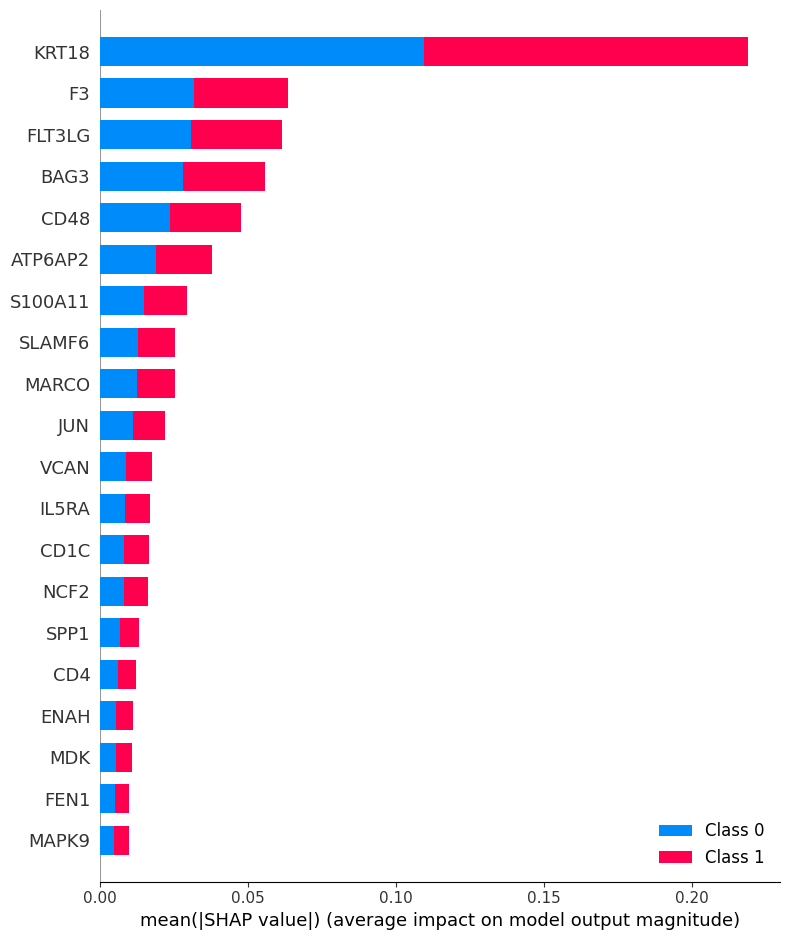

In [38]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test1,feature_names=X.columns, max_display =20,show=False )
plt.savefig('xai_mgh_scmgh.svg')

In [39]:
fig = px.area(
    x=fpr1, y=tpr1,
    title=f'ROC Curve (AUC={auc(fpr1, tpr1):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
# fig.write_image("fig1.svg")
# fig.show()
plotly.offline.plot(fig, filename='ppp', image='svg')

/usr/local/lib/python3.10/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `ppp` didn't end with .html. Adding .html to the end of your file.



'ppp.html'